In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os

In [2]:
methods = [
    'spanve','moranI', 'spatialDE', 'all_genes',
    'rank_genes_group','cell_ranger',
    'rank_genes_group+spanve', 'cell_ranger+spanve',
    'cell_ranger+moranI', 'cell_ranger+spatialDE'
]
deconv_tool = ['cell2loc','tangram', 'bayestme']
datasets = ['Dataset10', 'Dataset4']
base_dir = '.'

name_mapper = {
    'all_genes': 'All Genes',
    'spanve': 'Spanve',
    'moranI': r"moran's I",
    'cell_ranger': 'Cell Ranger',
    '+': ' + ',
    'rank_genes_group': 'markers from scRNA',
}
order = ['all_genes','spanve','moranI','spatialDE',
         'cell_ranger', 'cell_ranger+spanve', 'cell_ranger+moranI', 'cell_ranger+spatialDE',
         'rank_genes_group', 'rank_genes_group+spanve', 'rank_genes_group+moranI', 'rank_genes_group+spatialDE',
        ]
def change_name(s):
    s_ = s
    for k,v in name_mapper.items():
        if k in s_:
            s_ = s_.replace(k, v)
    return s_
order = [change_name(i) for i in order]

### Metrics

In [26]:
all_AS = []
all_scores = []
for dt in deconv_tool:
    for ds in datasets:
        metric_dir = os.path.join(base_dir, ds, 'metrics', dt)
        scores_dict = dict()
        for score_type in ['JSD','PCC','RMSE','SSIM']:
            scores_dict[score_type] = pd.read_csv(os.path.join(metric_dir, f'{score_type}_scores.csv'), index_col=0)

        # scores['AS'].index = [change_name(i) for i in scores['AS'].index]
        scores = pd.read_csv(os.path.join(metric_dir, 'AS_scores.csv'), index_col=0)
        sns.set_style('white')
        ax = sns.barplot(
            scores.drop(columns = ['AS']).T,
            orient='h',
            order = order,
            palette='tab20c',
            # errorbar = 'sd', 
            errwidth = 1, 
            saturation=1
        )
        sns.stripplot(
            scores.drop(columns = ['AS']).T,
            orient='h',
            order = order,
            color='.7', linewidth = 1, alpha = 0.5,
            ax = ax, jitter = False
        )
        ax.set_xlabel('Rank Score')
        ax.set_ylabel('Gene Select Methods')
        sns.despine(top=True, right=True, ax=ax, offset=10)
        plt.gcf().savefig(os.path.join(metric_dir,'RankScore.pdf'),bbox_inches='tight')
        plt.close()
        
        dfsep = scores['AS'].reset_index()
        dfsep['ds'] = ds
        dfsep['dt'] = dt
        dfsep.columns = ['FeatureSelect','Score','Dataset', 'Methods']
        all_AS.append(dfsep)
        scores_detailed = pd.concat(list(scores_dict.values()), keys= scores_dict.keys()).reset_index().rename(columns = {'level_0':'metrics', 'level_1':'celltype'})
        scores_detailed['decon_tools'] = dt
        scores_detailed['Dataset'] = {'Dataset4':'seqFISH+', 'Dataset10':'STARmap'}[ds]
        all_scores.append(scores_detailed)
all_scores = pd.concat(all_scores)
all_AS = pd.concat(all_AS)

/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.7'` for same effect.
  warnings.warn(msg, FutureWarning)
/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/share/anaconda3/envs/SpaBench/lib/python3.9/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.7'` for same effect.
  wa

In [30]:
all_scores.columns = all_scores.columns[0:2].tolist() + all_scores.columns[-2:].tolist() + all_scores.columns[2:-2].tolist()
all_AS.to_csv('./All_score_record.csv')
all_scores.to_csv('./all_score_record.csv', index=False)

In [4]:
order_group = {
    1: ['All Genes','Spanve',"moran's I",'spatialDE'],
    2: ['Cell Ranger','Cell Ranger + Spanve',"Cell Ranger + moran's I",'Cell Ranger + spatialDE'],
    3: ['markers from scRNA','markers from scRNA + Spanve',"markers from scRNA + moran's I",'markers from scRNA + spatialDE']
}

In [67]:
all_AS

,FeatureSelect,Score,Dataset,Methods
0,Cell Ranger + Spanve,0.916667,Dataset10,cell2loc
1,Cell Ranger + spatialDE,0.854167,Dataset10,cell2loc
2,Cell Ranger + moran's I,0.812500,Dataset10,cell2loc
3,All Genes,0.729167,Dataset10,cell2loc
4,markers from scRNA + Spanve,0.666667,Dataset10,cell2loc
...,...,...,...,...
7,Cell Ranger + spatialDE,0.458333,Dataset4,bayestme
8,moran's I,0.395833,Dataset4,bayestme
9,Cell Ranger + moran's I,0.375000,Dataset4,bayestme
10,markers from scRNA + spatialDE,0.250000,Dataset4,bayestme


In [94]:
def annote_line(
    ax, s, start, end, color="b", xgap=0, ygap=0, lw=4, fontsize=8, rotation=0,
    **kwargs
):
    an1 = ax.annotate(
        "",
        start,
        end,
        xycoords="data",
        horizontalalignment="left",
        verticalalignment="top",
        annotation_clip=False,
        arrowprops=dict(
            arrowstyle="-",
            color=color,
            lw=lw,
            # connectionstyle = 'bar'
            patchA = 0, patchB =0
        ),
    )

    an1_text = ax.annotate(
        s,
        ((start[0] + end[0]) / 2 - xgap, (start[1] + end[1]) / 2 - ygap),
        xycoords="data",
        horizontalalignment="center",
        verticalalignment="center",
        fontsize=fontsize,
        annotation_clip=False,
        rotation=rotation,
    )
    return an1, an1_text

def lighten_color(color, amount=0.5):
    import colorsys
    import matplotlib.colors as mc
    c = color

    try:
        c = mc.cnames[color]
    except KeyError:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

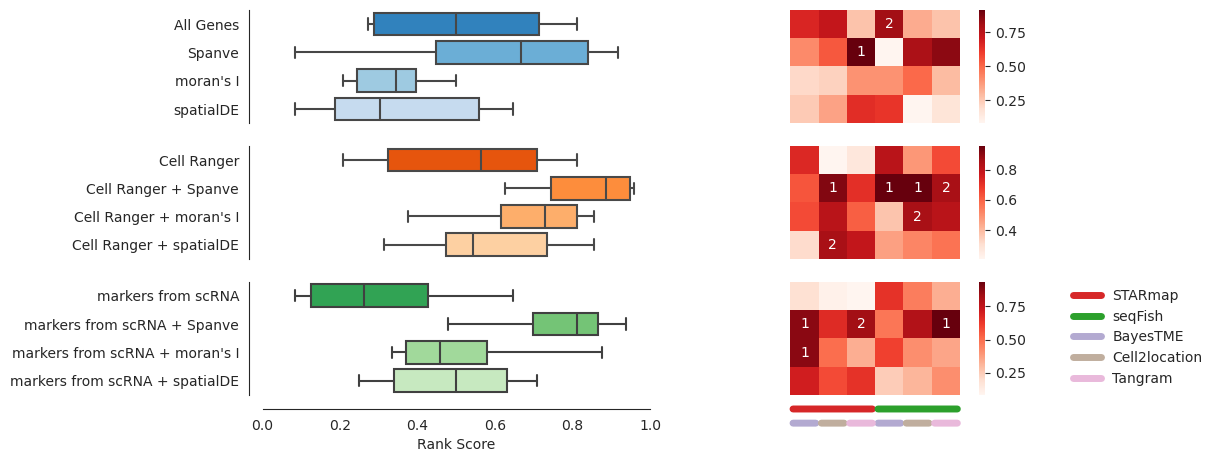

In [109]:
sns.set_style(rc = dict(fontsize = 12))
scale = 1.25
f, axes = plt.subplots(3,2, sharex=False, figsize = (8*scale,4*scale))
plt.subplots_adjust(wspace=0.)
palette = sns.color_palette('tab20c')

for i, ax in enumerate(axes[:,0]):
    targer_fs = order_group[i+1]
    sns.boxplot(
        all_AS.query('FeatureSelect in @targer_fs'), x = 'Score', y='FeatureSelect', #row = 'Dataset',
        orient='h', order=targer_fs,#kind = 'box',
        palette = palette[i*4: i*4+4], saturation=1, ax=ax,
        linewidth = 1.5
    )
    ax.set_ylabel('')
    ax.set_xlim(0,1)
    if i != 2:
        ax.set_xlabel('')
        ax.set_xticks([])
        sns.despine(top=True, right=True, ax=ax, bottom=True, offset=10)
    else:
        ax.set_xticks(np.linspace(0,1,6))
        ax.set_xlabel(
            'Rank Score',# fontsize = 10
        )
        sns.despine(top=True, right=True, ax=ax, offset=10)
    ax.set_ylabel(
        ax.get_ylabel(),
        # fontsize = 10
    )

dfvis = all_AS.pivot_table(
    values='Score', index = 'FeatureSelect', columns = ['Dataset','Methods']
).loc[order,:]

annot = (dfvis.shape[0] - dfvis.rank() + 1).astype(int)
msk = annot >=3
annot[msk] = ''
annot_colors = {
    'STARmap' : sns.color_palette('tab10')[3],
    'seqFish' : sns.color_palette('tab10')[2]
}

for i, ax in enumerate(axes[:,1]):
    targer_fs = order_group[i+1]
    
    dfvis = all_AS.query('FeatureSelect in @targer_fs').pivot_table(
        values='Score', index = 'FeatureSelect', columns = ['Dataset','Methods']
    ).loc[targer_fs,:]

    sns.heatmap(
        dfvis, cmap = 'Reds', cbar=True, square=True, annot=annot.loc[dfvis.index,:], fmt='', ax=ax
    )
    if i == 2:
        # ax.set_xticklabels(['BayesTME','Cell2location','Tangram']*2,rotation=60)
        
        ygap= -0.65
        y = -4.5
        lw = 5
        annote_line(ax,'',(0,-y),(3,-y), ygap=ygap, color = sns.color_palette('tab10')[3], lw = lw) # STARmap
        annote_line(ax,'',(3,-y),(6,-y), ygap=ygap, color = sns.color_palette('tab10')[2], lw = lw) # seqFish
        
        y = -5
        for xi, method in enumerate(['BayesTME','Cell2location','Tangram']):
            c = lighten_color(sns.color_palette('deep')[4+xi], amount = 0.6)
            annot_colors[method] = c
            annote_line(ax,'',(xi,-y),(xi+1,-y), ygap=ygap, color = c, lw = lw) 
            annote_line(ax,'',(xi+3,-y),(xi+4,-y), ygap=ygap, color = c, lw = lw)
            
    ax.set_xticks([])
    ax.set_xlabel('')
    ax.set_yticks([])
    ax.set_ylabel('')
    
ax.legend(
    handles = [plt.Line2D([],[], color = v, lw=5, label=k) for k,v in annot_colors.items()],
    frameon=False,# fontsize=10, 
    bbox_to_anchor=(2.5,1.05), 
)
f.savefig('AS_merged.pdf', bbox_inches='tight')

### Cell distribution

In [96]:
def process_cell2loc_res(cell2loc_results):
    cell2loc_results.index = np.arange(len(cell2loc_results))
    cell2loc_results.columns = [c.split('q05cell_abundance_w_sf_')[1] for c in cell2loc_results.columns]
    cell2loc_results = cell2loc_results.loc[:,np.unique(cell2loc_results.columns)]
    cell2loc_results = (cell2loc_results.T/cell2loc_results.sum(axis=1)).T
    cell2loc_results = cell2loc_results.fillna(0)
    cell2loc_results = cell2loc_results.drop(columns=['Other','Neuron Other','Inhibitory Other'])
    return cell2loc_results

def plot_cell_dist(decov_res, cidx, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    cell_prob_mat = np.zeros(gd_loc.max().values.astype(int)+1)
    for i in range(decov_res.shape[0]):
        x, y = gd_loc.iloc[i,:].astype(int)
        cell_prob_mat[x,y] = decov_res.iloc[i, cidx]
    sns.heatmap(cell_prob_mat.T, cmap='viridis', square=True, xticklabels=False, yticklabels = False, ax = ax, **kwargs)
    return ax

In [97]:
ds = 'Dataset10'

gd_results = pd.read_table('Dataset10/Simulated/combined_spot_clusters.txt', sep = '\t', header = 0, index_col = 0)
gd_results.columns = ['Astro', 'Endo', 'Excitatory L2/3', 'Excitatory L4', 'Excitatory L5', 'Excitatory L6', 'HPC', 'Micro', 'Npy'
                     , 'Olig', 'Other', 'Inhibitory Pvalb', 'Smc', 'Inhibitory Sst', 'Inhibitory Vip']
gd_results = (gd_results.T/gd_results.sum(axis=1)).T
gd_results = gd_results.drop(columns=['Other','Npy', 'HPC'])
gd_results = gd_results.loc[:,np.unique(gd_results.columns)]
gd_results = gd_results.fillna(0)
gd_loc = pd.read_csv('Dataset10/Simulated/combined_Locations.txt',sep='\t')
gd_loc = gd_loc - gd_loc.min()

In [98]:
gd_results.columns

Index(['Astro', 'Endo', 'Excitatory L2/3', 'Excitatory L4', 'Excitatory L5',
       'Excitatory L6', 'Inhibitory Pvalb', 'Inhibitory Sst', 'Inhibitory Vip',
       'Micro', 'Olig', 'Smc'],
      dtype='object')

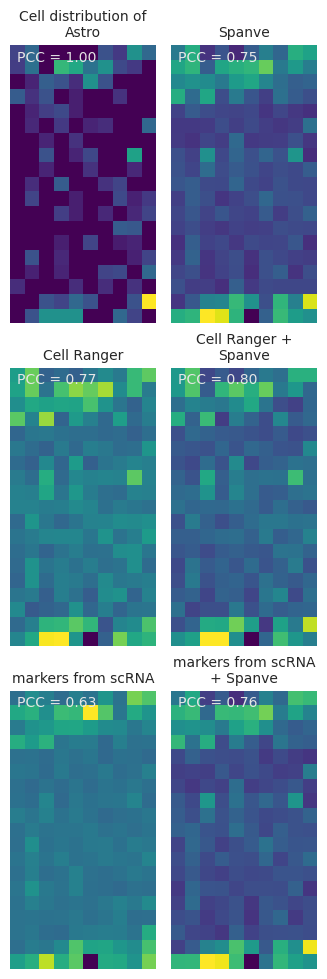

In [118]:
import sys
sys.path.append('../utils/')
from visulize_utils import change_text
scale_factor = 2
cidx = 0

f, axes = plt.subplots(3,2, figsize = (4*scale_factor,6*scale_factor))
plt.subplots_adjust(wspace=-0.65, hspace=0.16)
for fs, ax in zip(
    [
        'Ground Truth','spanve', 
        'cell_ranger', 'cell_ranger+spanve',
        'rank_genes_group', 'rank_genes_group+spanve'
    ],
    axes.flatten()
):
    ax.set_title(f"{change_text(change_name(fs), n=3)}", fontdict=dict(size=10))
    if fs == 'Ground Truth':
        res_sep = gd_results
        ax.set_title(f'Cell distribution of\n{gd_results.columns[cidx]}', fontdict=dict(size=10))
    else:
        file_dir = os.path.join(base_dir, ds, 'output', fs, 'Cell2location_result.csv')
        res_sep = process_cell2loc_res(pd.read_csv(file_dir, index_col=0))
    plot_cell_dist(res_sep, cidx=cidx, ax=ax, cbar = False, vmin=0)
    pcc = np.corrcoef(gd_results.iloc[:, cidx], res_sep.iloc[:, cidx])[0,1]
    
    ax.text(x = 0.5, y = 1.1, s = f'PCC = {pcc:.2f}', color = '.9')
# f.suptitle('Cell Type '+gd_results.columns[cidx]+' Deconvolution Result by cell2location', y=0.95)
f.savefig('./cell_dist_D10C0_cell2loc.pdf')

## Gene analysis

In [34]:
# get the unique Spanve genes
import scanpy as sc
from SelectGene import GeneSelector
import sys
sys.path.append('../utils/visulize_utils/venn/')
from venn import venn3, get_labels
merged_result = dict()
for ds in ['Dataset4','Dataset10']:
    n_genes = 200 if ds == 'Dataset10' else 1000
    scdata = sc.read_h5ad(f'./{ds}/{ds}_sc.h5ad')
    stdata = sc.read_h5ad(f'./{ds}/{ds}_Simulated_sp.h5ad')
    if ds == "Dataset4":
        stdata.uns['density'] = stdata.uns['density'].drop(columns=['Ependymal', 'NSC', 'Neuroblast', 'Non-known', 'OPC'])
    else:
        stdata.uns['density'] = stdata.uns['density'].drop(columns=['Other','Npy', 'HPC'])
    GS = GeneSelector(stdata, scdata, n_genes=n_genes)

    selected_dict = {}
    for method in ['spanve','moranI', 'spatialDE']:
        print(method)
        selected_dict[method] = GS.fit(method)

    expr_sep = stdata.to_df()
    dfmerge = pd.concat([expr_sep, stdata.uns['density']], axis=1)
    celltypes = stdata.uns['density'].columns
    dfmerge = dfmerge.loc[:,~dfmerge.columns.duplicated()]
    corrmat = dfmerge.corr()

    ct_most_predictive_genes = corrmat.loc[celltypes, stdata.var_names].apply(
        lambda x: (np.abs(x).sort_values(ascending=False).index[0:10]),axis=1)
    labels, items = get_labels(data = list(selected_dict.values()))
    all_genes = set([j for i in items.values() for j in i])
    merged_result[ds] = dict(
        selected_dict = selected_dict,
        corrmat = corrmat,
        labels = labels, items = items,
        ct_most_predictive_genes = ct_most_predictive_genes
    )

spanve
moranI
spatialDE


Models: 100%|██████████| 10/10 [00:29<00:00,  2.96s/it]


spanve
moranI
spatialDE


Models: 100%|██████████| 10/10 [00:36<00:00,  3.61s/it]


In [109]:
select_ct = 'Astro'
labeled_genes = ct_most_predictive_genes[select_ct]
missed_genes = set(labeled_genes) - all_genes
labels, items = get_labels(data = list(selected_dict.values()))
for k in items.keys():
    l = labeled_genes.intersection(items[k])
    sep = 2
    labels[k] += "\n" + '\n'.join( [' '.join(l[k:k+sep]) for k in range(0, len(l), sep)])

In [78]:
ng = pd.DataFrame(columns = ['method', 'dataset', 'n'])
for method in ['100','010','001']: # ['spanve','moranI', 'spatialDE']
    for ds in ['Dataset4','Dataset10']:
    # for ct in celltypes:
        corrmat = merged_result[ds]['corrmat']
        celltypes = merged_result[ds]['ct_most_predictive_genes'].index
        ct_most_predictive_genes = corrmat.loc[celltypes, corrmat.columns.drop(celltypes)].apply(
            lambda x: (np.abs(x).sort_values(ascending=False).index[0:30]),axis=1)
        items = merged_result[ds]['items']
        most_predictive_genes = set([i for j in ct_most_predictive_genes for i in j])
        ng.loc[len(ng)] = method, ds, len(most_predictive_genes.intersection(items[method]))
                  # items[method] ct_most_predictive_genes[ct] selected_dict

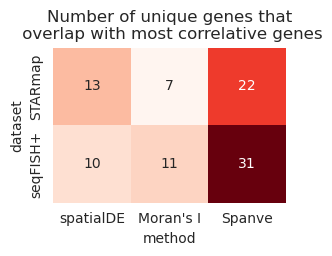

In [94]:
f, ax = plt.subplots(figsize=(3,3))
ax = sns.heatmap(
    ng.pivot(index = 'dataset', columns = 'method', values='n').rename(
        columns = {'001':'spatialDE', '010':'Moran\'s I', '100':'Spanve'},
        index = {'Dataset4':'seqFISH+','Dataset10':'STARmap'}
    ),
    square=True, cmap = 'Reds', annot=True, cbar = False, ax = ax, annot_kws = dict(fontsize = 10)
)
ax.set_title('Number of unique genes that\n overlap with most correlative genes', y=1)
f.savefig('./heat_overlap_most_predictive.pdf', bbox_inches = 'tight')

In [7]:
from tqdm import tqdm
corrmat = pd.DataFrame(index=celltypes, columns=list(all_genes))
for j in tqdm(corrmat.columns):
    for i in corrmat.index:
        corrmat.loc[i,j] = np.corrcoef(dfmerge.loc[:, i], dfmerge.loc[:,j])[0,1]

100%|██████████| 2378/2378 [00:06<00:00, 362.03it/s]


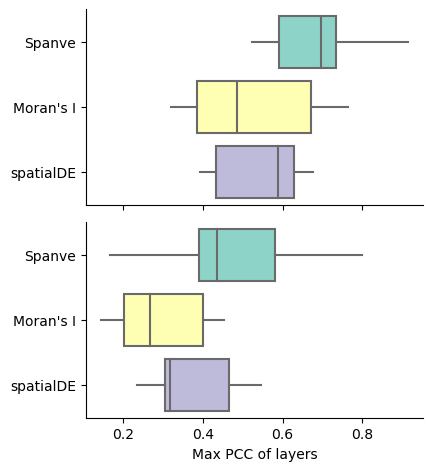

In [162]:
import seaborn as sns
dfvis = []
for ds in ['Dataset4','Dataset10']:
    corrmat = merged_result[ds]['corrmat']
    items = merged_result[ds]['items']
    celltypes = merged_result[ds]['ct_most_predictive_genes'].index
    
    max_cor = pd.concat(
        [
            np.abs(corrmat.loc[celltypes, list(items[method])]).max(axis=1)
            for method in ['100','010', '001']
        ], axis = 0, keys= ['spanve', 'moran', 'spatialDE']
    ).reset_index()
    max_cor.columns = ['methods', 'gene_name', 'values']
    max_cor['Dataset'] = ds
    dfvis.append(max_cor)
    
ax = sns.catplot(
    pd.concat(dfvis), y = 'methods', x = 'values', row = 'Dataset',
    palette = 'Set3', saturation=1,
    width=0.8, linewidth=1.5, 
    flierprops=dict(marker=".", markersize=3), showcaps = False,
    orient='h', kind= 'box',
)
ax.set_ylabels('')
ax.set_titles('')
ax.set_xlabels('Max PCC of layers')
ax.set_yticklabels(['Spanve',"Moran\'s I", 'spatialDE'])
scale = 1.5
ax.fig.set_figwidth(3*scale)
ax.fig.set_figheight(3*scale)
ax.savefig('./MaxPCC_Layers.pdf')

Text(1, 0, 'Missed genes\nFgfr3 Msmo1 Sdc4\nAtp1b2 Bcan S1pr1\nPantr1 Aqp4 Acsbg1\nPtprz1 Adarb2 Gpr37l1\nNtsr2 Prdx6 Mmd2\nMfge8 Htra1')

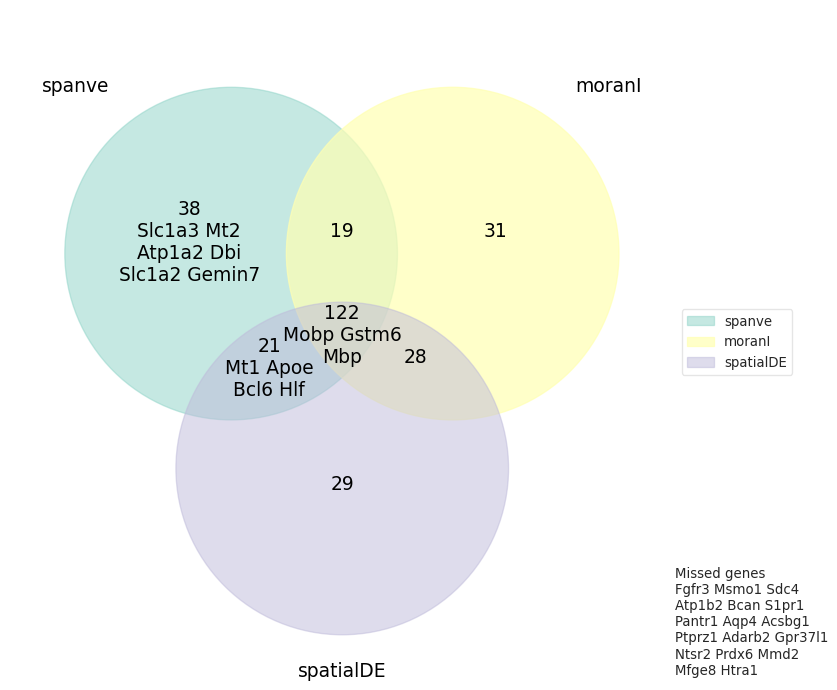

In [110]:
f, ax = venn3(
    labels, names=list(selected_dict.keys()),
    colors = [(*c, a) for c, a in zip(sns.color_palette('Set3')[0:3], (0.5, 0.7, 0.5))]
)
l = list(missed_genes)
sep = 3
ax.text(x = 1, y = 0, s = 'Missed genes\n'+'\n'.join( [' '.join(l[k:k+sep]) for k in range(0, len(l), sep)]))
# plt.savefig(f'venn_D10_{select_ct}.pdf', bbox_inches = 'tight')